In [1]:
from enum import Enum, auto
from dataclasses import dataclass, field
from typing import List
from copy import deepcopy
from itertools import combinations, product

from matplotlib import pyplot as plt

In [2]:
class BlockType(Enum):
    Sign = "sign"
    Digit = "digit"
    Equality = "equality"

SLOTS = {
    BlockType.Digit: (
        ((0, 0), (0, 1)),
        ((0, 1), (0, 2)),
        ((0, 2), (1, 2)),
        ((1, 1), (1, 2)),
        ((1, 0), (1, 1)),
        ((0, 0), (1, 0)),
        ((0, 1), (1, 1))
    ),
    BlockType.Sign: (
        ((0.5, 0.5), (0.5, 1.5)),
        ((0, 1), (1, 1))
    ),
    BlockType.Equality: (
        ((0, 0.5), (1, 0.5)),
        ((0, 1.5), (1, 1.5))
    )
}

class SlotColor:
    Empty = (0.7, 0.7, 0.7) # light grey
    Removed = "red"
    Added = "Green"
    Remaining = "yellow"

DIGITS = {
    (1, 1, 1, 1, 1, 1, 0): '0',
    (0, 0, 0, 1, 1, 0, 0): '1',
    (1, 0, 1, 1, 0, 1, 1): '2',
    (0, 0, 1, 1, 1, 1, 1): '3',
    (0, 1, 0, 1, 1, 0, 1): '4',
    (0, 1, 1, 0, 1, 1, 1): '5',
    (1, 1, 1, 0, 1, 1, 1): '6',
    (0, 0, 1, 1, 1, 0, 0): '7',
    (1, 1, 1, 1, 1, 1, 1): '8',
    (0, 1, 1, 1, 1, 1, 1): '9'
}

In [3]:
# import json
# p = {0: 0, 1: 2, 2: 4, 3: 6, 4: 5, 5: 1, 6: 3}
# d_slots = [SLOTS[BlockType.Digit][p[i]] for i in range(7)]
# new_digits = {tuple(k[p[i]] for i in range(7)): v for k, v in DIGITS.items()}
# print(d_slots)
# print(new_digits)

In [4]:
class Block:
    def __init__(self, block_type : BlockType, matches : List = None):
        assert isinstance(block_type, BlockType)
        self.indicators = list(matches) if matches else []
        self.type = block_type
        self._validate()
    
    def _validate(self):
        assert all(indicator in {0, 1} for indicator in self.indicators)
        if self.type == BlockType.Equality:
            assert len(self.indicators) == 0
        elif self.type == BlockType.Sign:
            assert len(self.indicators) == 1
        else:
            assert self.type == BlockType.Digit
            assert len(self.indicators) == 7
    
    def add_match(self, index):
        assert self.indicators[index] == 0
        self.indicators[index] = 1
    
    def remove_match(self, index):
        assert self.indicators[index] == 1
        self.indicators[index] = 0

    def available_matches(self):
        return [slot for slot, indicator in enumerate(self.indicators) if indicator == 1]
    
    def absent_matches(self):
        return [slot for slot, indicator in enumerate(self.indicators) if indicator == 0]
    
    def is_valid(self):
        if self.type in {BlockType.Sign, BlockType.Equality}:
            return True
        return tuple(self.indicators) in DIGITS
    
    def get_str(self):
        assert self.is_valid()
        if self.type == BlockType.Equality:
            return "=="
        if self.type == BlockType.Sign:
            return "+" if self.indicators[0] else "-"
        if self.type == BlockType.Digit:
            return DIGITS[tuple(self.indicators)]

    @classmethod
    def from_symbol(cls, symbol):
        if symbol == "=":
            return cls(BlockType.Equality)
        elif symbol in {"-", "+"}:
            return cls(BlockType.Sign, [1 if symbol == "+" else 0])
        else:
            assert symbol in DIGITS.values(), "bad symbol: {}".format(symbol)
            for indicators, val in DIGITS.items():
                if val == symbol:
                    return cls(BlockType.Digit, indicators)

class MatchConfiguration:
    def __init__(self, blocks):
        self.blocks = [Block(b.type, b.indicators) for b in blocks]
    
    @classmethod
    def from_str(cls, s):
        return cls(Block.from_symbol(symbol) for symbol in s if not symbol.isspace())

    def is_valid(self):
        if any(not b.is_valid() for b in self.blocks):
            return False
        if all(b.type != BlockType.Equality for b in self.blocks):
            return True
        py_expression = "".join(b.get_str() for b in self.blocks)
        return eval(py_expression)
    
    def add_match(self, block_id, slot_index):
        self.blocks[block_id].add_match(slot_index)
    
    def remove_match(self, block_id, slot_index):
        self.blocks[block_id].remove_match(slot_index)

    def available_matches(self):
        result = []
        for block_id, block in enumerate(self.blocks):
            for slot_index in block.available_matches():
                result.append((block_id, slot_index))
        return result
    
    def absent_matches(self):
        result = []
        for block_id, block in enumerate(self.blocks):
            for slot_index in block.absent_matches():
                result.append((block_id, slot_index))
        return result
    


In [5]:
            
class Solution:
    def __init__(self, configuration : MatchConfiguration, removed_matches=(), added_matches=()):
        self.block_types = [block.type for block in configuration.blocks]
        self.slot_colors = []
        for block in configuration.blocks:
            if block.type == BlockType.Equality:
                self.slot_colors.append([SlotColor.Remaining] * 2)
            elif block.type == BlockType.Sign:
                self.slot_colors.append(
                    [SlotColor.Remaining if block.indicators[0] else SlotColor.Empty,
                     SlotColor.Remaining]
                )
            else:
                self.slot_colors.append([
                    SlotColor.Remaining if i else SlotColor.Empty for i in block.indicators
                ])
        for block_id, slot_id in removed_matches:
            self.slot_colors[block_id][slot_id] = SlotColor.Removed
        for block_id, slot_id in added_matches:
            self.slot_colors[block_id][slot_id] = SlotColor.Added
    
    def get_numbers(self):
        curr_number = []
        numbers = []
        for t, block_clors in zip(self.block_types, self.slot_colors):
            if t == BlockType.Digit:
                fixed_digit = tuple(
                    int(color in (SlotColor.Remaining, SlotColor.Added))
                    for color in block_clors
                )
                assert fixed_digit in DIGITS
                curr_number.append(DIGITS[fixed_digit])
            else:
                assert curr_number, "empty number"
                numbers.append(int("".join(curr_number)))
                curr_number = []
        assert curr_number, "empty number"
        numbers.append(int("".join(curr_number)))
        return numbers

    def get_sign(self):
        assert self.block_types.count(BlockType.Sign) == 1
        sign_index = self.block_types.index(BlockType.Sign)
        if self.slot_colors[sign_index][0] in (SlotColor.Remaining, SlotColor.Added):
            return "plus"
        else:
            return "minus"
        
    def plot(self, scale = 100, padding=20, figsize=(20, 10)):
        figure, axes = plt.subplots(1, len(self.block_types), squeeze=False, figsize=figsize)
        axes = axes[0]
        for block_type, colors, ax in zip(self.block_types, self.slot_colors, axes):
            ax.set_xlim(0, scale + 2 * padding)
            ax.set_ylim(0, 2 * scale + 2 * padding)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_aspect('equal')
            for ((x, y), (x2, y2)), color in zip(SLOTS[block_type], colors):
                ax.arrow(
                    padding + scale * x,
                    padding + scale * y,
                    scale * (x2 - x),
                    scale * (y2 - y),
                    color = color,
                    linewidth=5
                )
#         figure.show()
        


In [6]:
def search_solutions(configuration, add_count, delete_count, verbose=False):
    available_matches = configuration.available_matches()
    absent_matches = configuration.absent_matches()
    solutions = []
    for removed_matches in combinations(available_matches, delete_count):
        for added_matches in combinations(absent_matches, add_count):
            for block_id, slot_index in removed_matches:
                configuration.remove_match(block_id, slot_index)
            for block_id, slot_index in added_matches:
                configuration.add_match(block_id, slot_index)
            if configuration.is_valid():
                solution = Solution(
                    configuration,
                    removed_matches,
                    added_matches
                )
                solutions.append(solution)
                if verbose:
                    solution.plot()
            for block_id, slot_index in removed_matches:
                configuration.add_match(block_id, slot_index)
            for block_id, slot_index in added_matches:
                configuration.remove_match(block_id, slot_index)
    return solutions

In [7]:
def generate_problem_json(configuration : MatchConfiguration, add_count, delete_count, solutions=None):
    if solutions is None:
        solutions = search_solutions(configuration, add_count, delete_count)
    if add_count == 0 and delete_count > 0:
        action = "remove"
    elif add_count > 0 and delete_count == 0:
        action = "add"
    elif add_count > 0 and delete_count == add_count:
        action = "move"
    else:
        assert False, "bad task: can only move, add and remove matches"
    block_types = [block.type for block in configuration.blocks]
    digits_only = all(t == BlockType.Digit for t in block_types)
    if not digits_only:
        assert (
            block_types == [BlockType.Digit, BlockType.Sign, BlockType.Digit, BlockType.Equality, BlockType.Digit]
        ), "Can handle only one-digit numbers in problems with equalities"
    if digits_only:
        assert len(solutions) > 0
    else:
        assert len(solutions) == 1, "Can't generate json for problem with equality and many solutions"
    
    js = {
        "action": action,
        "quality": max(add_count, delete_count)
    }
    if digits_only:
        js["firstNumber"] = [block.indicators[:] for block in configuration.blocks]
        js["expected"] = [sol.get_numbers() for sol in solutions]
    else:
        js["sign"] = "plus" if configuration.blocks[1].indicators[0] else "minus"
        js["firstNumber"] = [configuration.blocks[0].indicators[:]]
        js["secondNumber"] = [configuration.blocks[2].indicators[:]]
        js["thirdNumber"] = [configuration.blocks[4].indicators[:]]
        js["expected"] = [solutions[0].get_numbers()]
        js["expectedSign"] = solutions[0].get_sign()
    return js

## Examples

[6]
[0]


{'action': 'move',
 'quality': 1,
 'firstNumber': [[0, 1, 1, 1, 1, 1, 1]],
 'expected': [[6], [0]]}

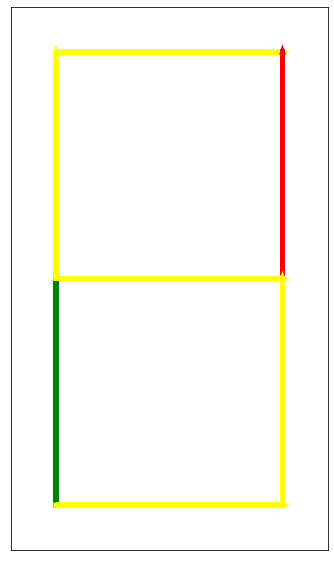

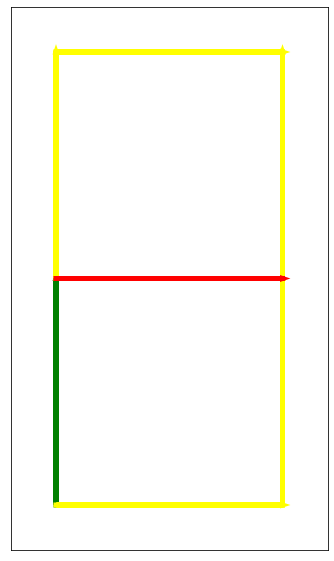

In [8]:
conf = MatchConfiguration([Block.from_symbol('9')])
solutions = search_solutions(conf, 1, 1, verbose=True)
for sol in solutions:
    print(sol.get_numbers())
generate_problem_json(conf, 1, 1)

[3, 3, 6]


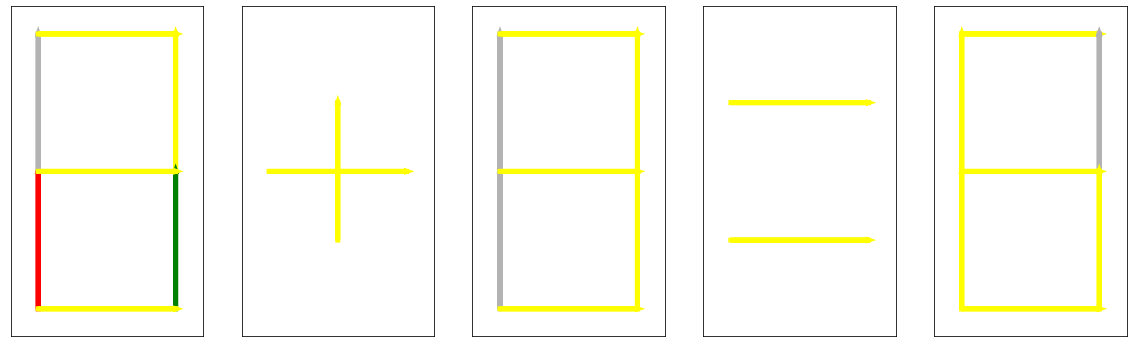

In [9]:
conf = MatchConfiguration.from_str("2+3=6")
solutions = search_solutions(conf, add_count=1, delete_count=1, verbose=True)
for sol in solutions:
    print(sol.get_numbers())

[9, 3, 6]
[8, 3, 5]


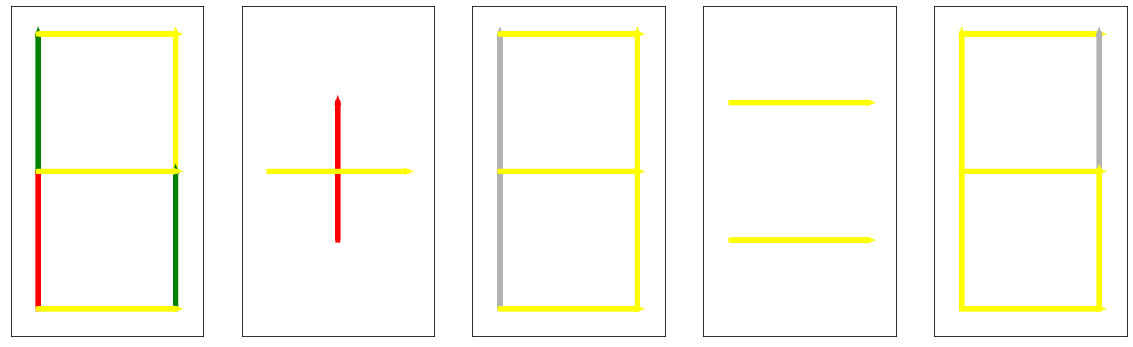

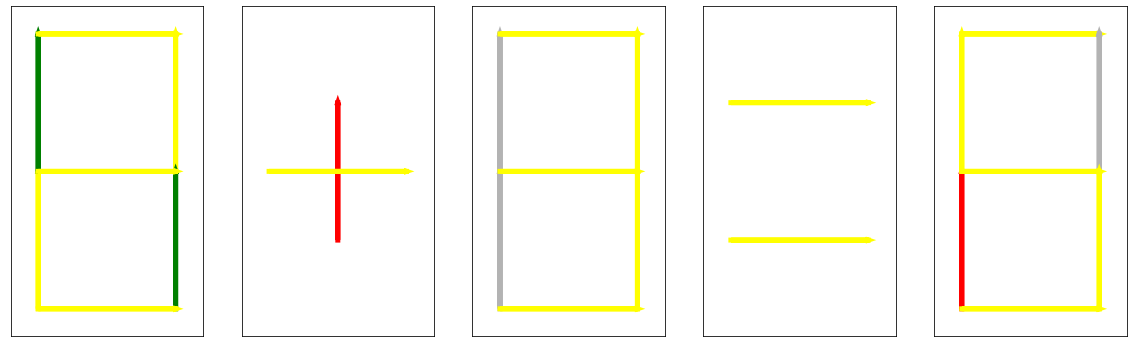

In [10]:
conf = MatchConfiguration.from_str("2+3=6")
solutions = search_solutions(conf, add_count=2, delete_count=2, verbose=True)
for sol in solutions:
    print(sol.get_numbers())

In [11]:
conf = MatchConfiguration.from_str("2+3=6")
search_solutions(conf, add_count=2, delete_count=0, verbose=True)

[]

In [12]:
conf = MatchConfiguration.from_str("2+3=6")
search_solutions(conf, add_count=0, delete_count=2, verbose=True)

[]

In [13]:
conf = MatchConfiguration.from_str("2+3 = 6")
search_solutions(conf, add_count=1, delete_count=0, verbose=True)

[]

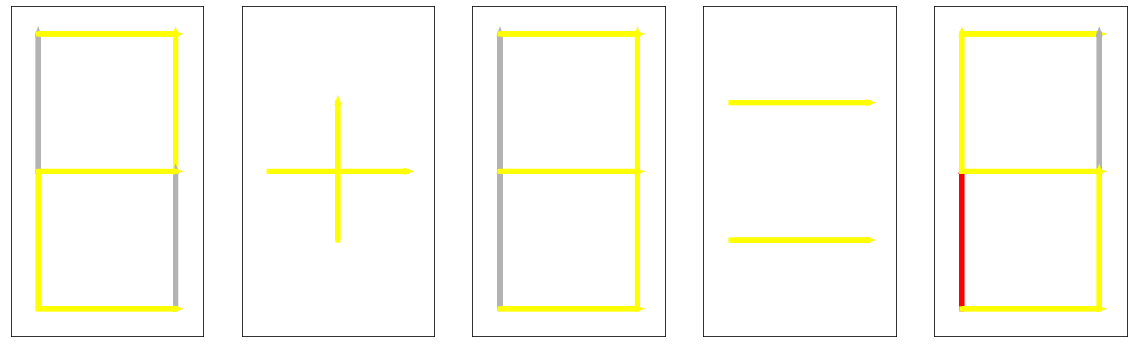

In [14]:
conf = MatchConfiguration.from_str("2 + 3 = 6")
search_solutions(conf, add_count=0, delete_count=1, verbose=True)

In [15]:
def generate_equations(add_count, delete_count):
    equations = []
    jsons = []
    for a, b, sign, c in product(range(10), range(10), ["-", "+"], range(10)):
        equation = "{}{}{}={}".format(a, sign, b, c)
        if eval(equation.replace("=", "==")) == False:
            conf = MatchConfiguration.from_str(equation)
            solutions = search_solutions(conf, add_count, delete_count)
            if len(solutions) == 1:
                equations.append(equation)
                jsons.append(generate_problem_json(conf, add_count, delete_count, solutions=solutions))
    return equations, jsons

In [16]:
add_one_match_equations, add_one_match_jsons = generate_equations(1, 0)
print(len(add_one_match_equations))
print(add_one_match_equations[:5])
print(add_one_match_jsons[0])

203
['0-0=8', '0-1=1', '0-1=7', '0+1=7', '0+1=9']
{'action': 'add', 'quality': 1, 'sign': 'minus', 'firstNumber': [[1, 1, 1, 1, 1, 1, 0]], 'secondNumber': [[1, 1, 1, 1, 1, 1, 0]], 'thirdNumber': [[1, 1, 1, 1, 1, 1, 1]], 'expected': [[8, 0, 8]], 'expectedSign': 'minus'}


In [17]:
move_one_match_equations, move_one_match_jsons = generate_equations(1, 1)
print(len(move_one_match_fixes))
print(move_one_match_fixes[:5])
print(move_one_match_jsons[0])

NameError: name 'move_one_match_fixes' is not defined

In [ ]:
move_two_match_equations, move_two_match_jsons = generate_equations(2, 2)
print(len(move_two_match_fixes))
print(move_two_match_fixes[:5])
print(move_two_match_jsons[0])

## Tests


In [ ]:
eval("1+2==4")

In [ ]:
list(combinations(range(5), 4))

In [ ]:
# test block copy
block1 = Block(BlockType.Digit, [1] * 7)
block2 = deepcopy(block1)

assert block1.indicators == block2.indicators
assert not block1.indicators is block2.indicators
block1.remove_match(1)
assert block1.indicators != block2.indicators

assert not block1.is_valid()
assert block2.is_valid()

# test block validation
for indicators in DIGITS:
    assert Block(BlockType.Digit, indicators).is_valid()
assert not Block(BlockType.Digit, [0] * 7).is_valid()
assert not Block(BlockType.Digit, [0] * 3 + [1] * 4).is_valid()


In [ ]:
sol = Solution(MatchConfiguration([Block.from_symbol(str(i)) for i in range(10)]))
sol.plot()